In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
df = pd.read_csv('train.csv')

df.isnull().sum()

# Drop rows with any missing values
df = df.dropna()
df.isnull().sum()

# Remove negative values
df = df[df['Quantity'] >= 1]
df = df[df['Amount'] >= 1]

# Convert 'Quantity' to numeric, invalid parsing will be set as NaN
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')

# Convert 'Amount' to numeric, invalid parsing will be set as NaN
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

# Check if any NaN values are present in the DataFrame
has_nan = df.isna().any().any()

# Convert date from object -> dateTime datatype
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

# convert data to month
df['YearMonth'] = df['Date'].dt.to_period('M') 

# Group by 'YearMonth' and sum the 'Quantity' column
monthly_sales = df.groupby('YearMonth').agg({
    'Quantity': 'sum',
    'Amount': 'sum'
}).reset_index()

monthly_sales['YearMonth'] = monthly_sales['YearMonth'].dt.to_timestamp()

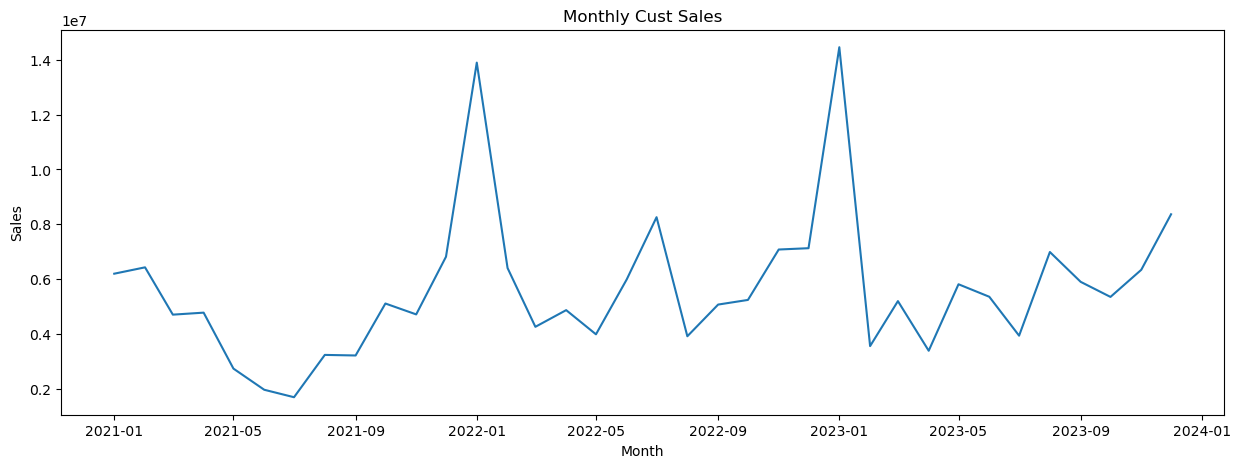

In [37]:
# Plot monthly cust sales
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Amount'])
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Cust Sales')
plt.show()

In [38]:
# Calculate the difference in sales amount between consecutive months
monthly_sales['sales_diff'] = monthly_sales['Amount'].diff()

# Display the first 10 rows of the DataFrame to visualize the changes
monthly_sales.head(10)

,YearMonth,Quantity,Amount,sales_diff
0,2021-01-01,69868.0,6196261.50,NaN
1,2021-02-01,58389.0,6428422.96,232161.46
2,2021-03-01,49756.0,4701558.12,-1726864.84
3,2021-04-01,52804.0,4774452.73,72894.61
4,2021-05-01,29090.0,2732032.26,-2042420.47
5,2021-06-01,21155.0,1959852.55,-772179.71
6,2021-07-01,20387.0,1687256.06,-272596.49
7,2021-08-01,34203.0,3231887.56,1544631.50
8,2021-09-01,28793.0,3211007.59,-20879.97
9,2021-10-01,50698.0,5107856.66,1896849.07


In [39]:
# Create a supervised learning dataset by shifting the 'sales_diff' column
supervised_df = monthly_sales.dropna(subset=['sales_diff']).reset_index(drop=True)

# Drop unnecessary columns
supervised_df = monthly_sales.drop(columns=['YearMonth', 'Quantity', 'Amount'])

print('Supervised Data Shape:', supervised_df.shape)

Supervised Data Shape: (36, 1)


In [40]:
# prepare supervised data
for i in range (1,13):
    col_name = 'month_' + str(i)
    supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

# Drop all rows with NaN values
supervised_df = supervised_df.dropna().reset_index(drop=True)

print('Supervised Data Shape:', supervised_df.shape)

Supervised Data Shape: (23, 13)


In [41]:
supervised_df.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-7498304.55,7085698.27,2104740.36,-397345.80,1896849.07,-20879.97,1544631.50,-272596.49,-772179.71,-2042420.47,72894.61,-1726864.84,232161.46
1,-2145142.00,-7498304.55,7085698.27,2104740.36,-397345.80,1896849.07,-20879.97,1544631.50,-272596.49,-772179.71,-2042420.47,72894.61,-1726864.84
2,608744.50,-2145142.00,-7498304.55,7085698.27,2104740.36,-397345.80,1896849.07,-20879.97,1544631.50,-272596.49,-772179.71,-2042420.47,72894.61
3,-882829.64,608744.50,-2145142.00,-7498304.55,7085698.27,2104740.36,-397345.80,1896849.07,-20879.97,1544631.50,-272596.49,-772179.71,-2042420.47
4,2006650.99,-882829.64,608744.50,-2145142.00,-7498304.55,7085698.27,2104740.36,-397345.80,1896849.07,-20879.97,1544631.50,-272596.49,-772179.71
5,2268752.64,2006650.99,-882829.64,608744.50,-2145142.00,-7498304.55,7085698.27,2104740.36,-397345.80,1896849.07,-20879.97,1544631.50,-272596.49
6,-4346210.39,2268752.64,2006650.99,-882829.64,608744.50,-2145142.00,-7498304.55,7085698.27,2104740.36,-397345.80,1896849.07,-20879.97,1544631.50
7,1156873.49,-4346210.39,2268752.64,2006650.99,-882829.64,608744.50,-2145142.00,-7498304.55,7085698.27,2104740.36,-397345.80,1896849.07,-20879.97
8,169142.55,1156873.49,-4346210.39,2268752.64,2006650.99,-882829.64,608744.50,-2145142.00,-7498304.55,7085698.27,2104740.36,-397345.80,1896849.07
9,1840177.21,169142.55,1156873.49,-4346210.39,2268752.64,2006650.99,-882829.64,608744.50,-2145142.00,-7498304.55,7085698.27,2104740.36,-397345.80


In [42]:
# Split data into training and testing sets
train_data = supervised_df[:-12]
test_data = supervised_df[-12:]

print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (11, 13)
Test Data Shape: (12, 13)


In [43]:
# Standardize training and testing data using MinMaxScaler (-1, 1)
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [44]:
# Split data into training and testing sets
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]

# Reshape target variables to 1D arrays
y_train = y_train.ravel()
y_test = y_test.ravel()

# Print the shapes of training and testing sets
print('X_train Shape: ', x_train.shape)
print('y_train Shape: ', y_train.shape)
print('x_test Shape: ', x_test.shape)
print('y_test Shape: ', y_test.shape)

X_train Shape:  (11, 12)
y_train Shape:  (11,)
x_test Shape:  (12, 12)
y_test Shape:  (12,)


In [45]:
# Creating a DataFrame to store predictions
sales_dates = monthly_sales['YearMonth'].iloc[-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
predict_df.columns = ['YearMonth']

In [46]:
# Actual sales
actual_sales = monthly_sales['Amount']

In [47]:
# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [48]:
# Reshape the predicted values for compatibility with the scaler
lr_pre = lr_pre.reshape(-1, 1)

# Concatenate predicted values with the original features of the test set
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)

# Inverse transform the scaled predicted values and features back to original scale
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [50]:
# Calculating predicted sales
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + actual_sales[index])
    
lr_predict_series = pd.Series(result_list, name='Linear Prediction')

In [51]:
# Merging with prediction DataFrame
predict_df = predict_df.merge(lr_predict_series, left_index = True, right_index = True)

# Model Evaluation
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['Amount'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['Amount'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['Amount'][-12:])

print(f"Linear Regression MSE: {lr_mse}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression R2 Score: {lr_r2}")

Linear Regression MSE: 6188804.444250978
Linear Regression MAE: 3905766.1153474203
Linear Regression R2 Score: -2.5766691519617893


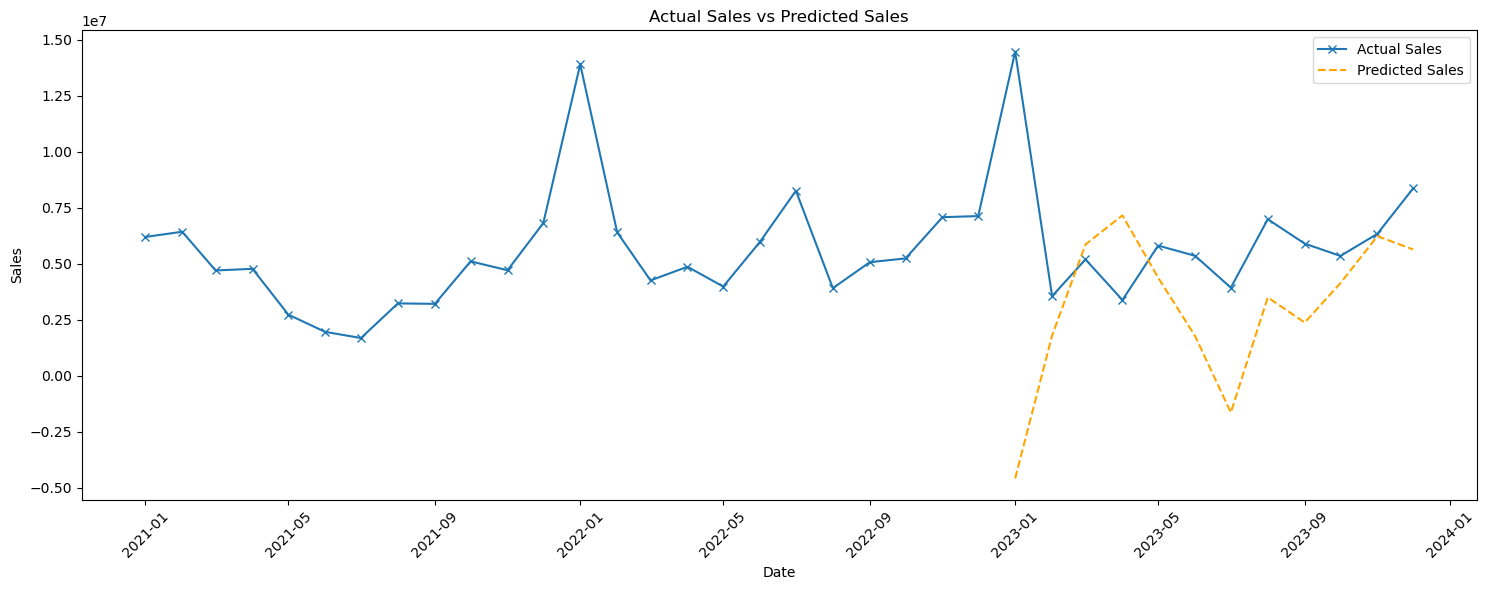

In [52]:
# Plotting
plt.figure(figsize=(15, 6))

# Plot actual sales for the full range
plt.plot(monthly_sales['YearMonth'], actual_sales, label='Actual Sales', marker='x', linestyle='-')

# Plot predicted sales only for the prediction period
plt.plot(predict_df['YearMonth'], predict_df['Linear Prediction'], label='Predicted Sales', linestyle='--', color='orange')

plt.title('Actual Sales vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()